### 运行前先装一个PyEMD库     是pip install pyemd pip install PyEMD，还是pip install EMD-signal 试着装哪个成功
### pip install -i https://pypi.tuna.tsinghua.edu.cn/simple xgboost 命令安装xgboost

In [9]:
# 调用相关库
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from PyEMD import CEEMDAN, Visualisation
from scipy.io import savemat,loadmat
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame
from pandas import concat
import numpy
import os
import copy
import scipy as spy
import math
from scipy.spatial.distance import cdist
from numpy import dot, exp
import xgboost as xgb

C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# 转换成监督数据，将每个特征转换成21列数据，20->1，20组预测一组
def series_to_supervised(data, n_in=20, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]  #计算特征的数量
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    # 将20组输入数据依次向下移动20,19,...3,2,1行，将数据加入cols列表（技巧：(n_in, 0, -1)中的-1指倒序循环，步长为1）
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # 将一组输出数据加入cols列表（技巧：其中i=0）
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # cols列表(list)中现在有21块经过下移后的数据(即：df(-20),df(-19),...df(-2),df(-1),df)，将四块数据按列 并排合并
    agg = pd.concat(cols, axis=1)
    # 给合并后的数据添加列名
    agg.columns = names
    # print(agg)
    # 删除NaN值列
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
dataset = pd.read_excel("816480.xlsx")
fratures_Corrected_irradiance = [
    'Flow (Veh/5 Minutes)'
]
values = dataset[fratures_Corrected_irradiance].values
n_features=1 #特征数量

In [4]:
values = values.astype('float32')
close = values

In [5]:
close=close.reshape(-1,1)
close.shape

(1440, 1)

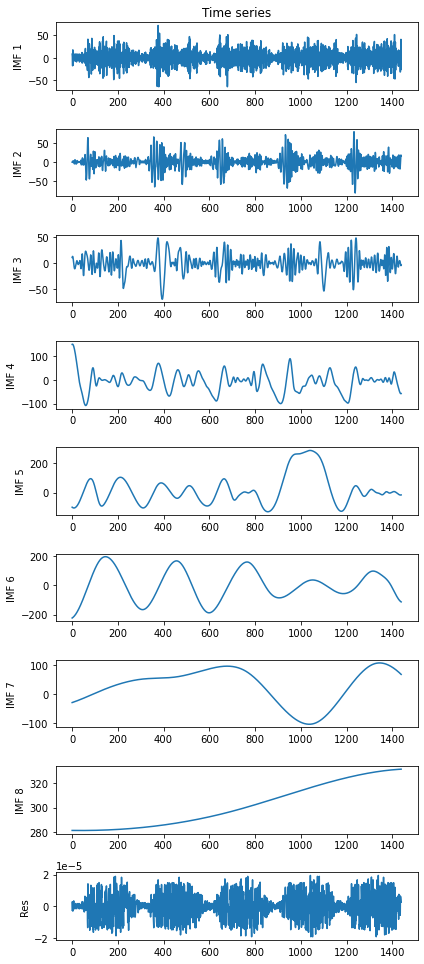

In [6]:
ceemdan = CEEMDAN()  
# ceemdan = CEEMDAN(trials = 500,epsilon = 0.3)   
ceemdan.ceemdan(close.reshape(-1))
imfs_close, res_close = ceemdan.get_imfs_and_residue()

t = np.arange(0, close.shape[0], 1)
vis = Visualisation()
vis.plot_imfs(imfs=imfs_close, residue=res_close, t=t, include_residue=True)
# vis.plot_instant_freq(t, imfs=imfs)
vis.show()

In [10]:
prediction_test = []
actual_test = []

for imf in imfs_close:
    imf=imf.reshape(-1,1)
    imf=pd.DataFrame(imf)
    data_=imf.values
    data_ = data_.astype('float32')
    # 标准化/放缩 特征值在（0,1）之间
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data_)
    
    n_in = 3
    n_out = 1
    # 构造一个20->1的监督学习型数据
    reframed = series_to_supervised(scaled, n_in=n_in, n_out=n_out)
    values=reframed.values
    
    #训练集和测试集的划分比例
    ratio=0.8 
    N=int(len(values) *ratio)
    train = values[:N, :]
    test = values[N:, :]

    # 划分输入和输出,split into input and outputs
    n_obs = n_in * n_features
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    train_y=train_y.reshape(-1,1)
    
    
        # In[] 参数设置
    XGB = xgb.XGBRegressor(n_estimators=100,learning_rate = 0.03, max_depth=6,n_jobs=-1,)
    model= XGB.fit(train_X, train_y)
   
    
    
    
    #预测
    yhat = model.predict(test_X)
    yhat=yhat.reshape(-1,1)
    # 对预测结果进行反归一化
    inv_yhat = scaler.inverse_transform(yhat)
    prediction_test.append(inv_yhat)
    # 将真实列据进行反归一化
    test_y=test_y.reshape(-1,1)
    inv_y = scaler.inverse_transform(test_y)
    actual_test.append(inv_y)
    
    





#####残差
imf=res_close.reshape(-1,1)
imf=imf.reshape(-1,1)
imf=pd.DataFrame(imf)
data_=imf.values
data_ = data_.astype('float32')
#    标准化/放缩 特征值在（0,1）之间
scaler = StandardScaler()
scaled = scaler.fit_transform(data_)
    
n_in = 3
n_out = 1
# 构造一个20->1的监督学习型数据
reframed = series_to_supervised(scaled, n_in=n_in, n_out=n_out)
values=reframed.values
    
#训练集和测试集的划分比例
ratio=0.8 
N=int(len(values) *ratio)
train = values[:N, :]
test = values[N:, :]

# 划分输入和输出,split into input and outputs
n_obs = n_in * n_features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
train_y=train_y.reshape(-1,1)
    
XGB = xgb.XGBRegressor(n_estimators=100,learning_rate = 0.03, max_depth=6,n_jobs=-1,)
model= XGB.fit(train_X, train_y)
  
    
#预测
yhat = model.predict(test_X)
yhat=yhat.reshape(-1,1)
# 对预测结果进行反归一化
inv_yhat = scaler.inverse_transform(yhat)
prediction_test.append(inv_yhat)
# 将真实列据进行反归一化
test_y=test_y.reshape(-1,1)
inv_y = scaler.inverse_transform(test_y)
actual_test.append(inv_y)

(1149, 3) (1149,) (288, 3) (288,)
(1149, 3) (1149,) (288, 3) (288,)
(1149, 3) (1149,) (288, 3) (288,)
(1149, 3) (1149,) (288, 3) (288,)
(1149, 3) (1149,) (288, 3) (288,)
(1149, 3) (1149,) (288, 3) (288,)
(1149, 3) (1149,) (288, 3) (288,)
(1149, 3) (1149,) (288, 3) (288,)
(1149, 3) (1149,) (288, 3) (288,)


In [11]:
mean_pre_test = []                    

for i in range(0,len(prediction_test[0])):
    sum = 0
    for j in range(0,len(prediction_test)):
        sum = sum + prediction_test[j][i]

    mean_pre_test.append(sum)
        
mean_pre_test        

[array([145.75659], dtype=float32),
 array([160.97644], dtype=float32),
 array([166.39139], dtype=float32),
 array([149.04587], dtype=float32),
 array([158.8139], dtype=float32),
 array([127.137634], dtype=float32),
 array([116.01657], dtype=float32),
 array([135.36606], dtype=float32),
 array([155.53244], dtype=float32),
 array([151.92023], dtype=float32),
 array([111.99782], dtype=float32),
 array([121.541245], dtype=float32),
 array([120.115875], dtype=float32),
 array([116.39984], dtype=float32),
 array([106.32245], dtype=float32),
 array([121.5896], dtype=float32),
 array([116.14105], dtype=float32),
 array([110.783966], dtype=float32),
 array([105.258514], dtype=float32),
 array([95.23108], dtype=float32),
 array([100.263916], dtype=float32),
 array([99.54141], dtype=float32),
 array([101.23956], dtype=float32),
 array([90.764694], dtype=float32),
 array([95.364914], dtype=float32),
 array([89.89378], dtype=float32),
 array([105.00523], dtype=float32),
 array([84.55615], dtype=fl

In [12]:
mean_actual_test = []

for i in range(0,len(actual_test[0])):
    sum = 0
    for j in range(0,len(actual_test)):
        sum = sum + actual_test[j][i]

    mean_actual_test.append(sum)
        
mean_actual_test    

[array([114.000015], dtype=float32),
 array([104.999985], dtype=float32),
 array([91.000015], dtype=float32),
 array([176.00002], dtype=float32),
 array([141.00002], dtype=float32),
 array([110.999985], dtype=float32),
 array([107.999985], dtype=float32),
 array([111.], dtype=float32),
 array([121.999985], dtype=float32),
 array([136.], dtype=float32),
 array([88.99997], dtype=float32),
 array([105.000015], dtype=float32),
 array([84.], dtype=float32),
 array([88.999985], dtype=float32),
 array([79.000015], dtype=float32),
 array([101.999985], dtype=float32),
 array([107.], dtype=float32),
 array([76.], dtype=float32),
 array([85.], dtype=float32),
 array([70.999985], dtype=float32),
 array([78.00003], dtype=float32),
 array([75.999985], dtype=float32),
 array([84.000015], dtype=float32),
 array([57.], dtype=float32),
 array([85.00003], dtype=float32),
 array([71.000015], dtype=float32),
 array([83.], dtype=float32),
 array([61.], dtype=float32),
 array([61.], dtype=float32),
 array([6

In [16]:
# 计算RMSE
def mape(y_true, y_pred):
    #评价指标MAPE
    record=[]
    for index in range(len(y_true)):
        if abs(y_true[index])>10:
            temp_mape=np.abs((y_pred[index] - y_true[index]) / y_true[index])
            record.append(temp_mape)
    return np.mean(record) * 100
rmse = sqrt(mean_squared_error(mean_actual_test, mean_pre_test))
print('Test RMSE: %.7f' % rmse)
print('Test MAE: %.7f' % mean_absolute_error(mean_actual_test, mean_pre_test))
print('Test MAPE: %.7f' % mape(mean_actual_test, mean_pre_test))
print('Test R2: %.7f' % r2_score(mean_actual_test, mean_pre_test))

Test RMSE: 23.1164179
Test MAE: 18.6369381
Test MAPE: 8.7183625
Test R2: 0.9799359


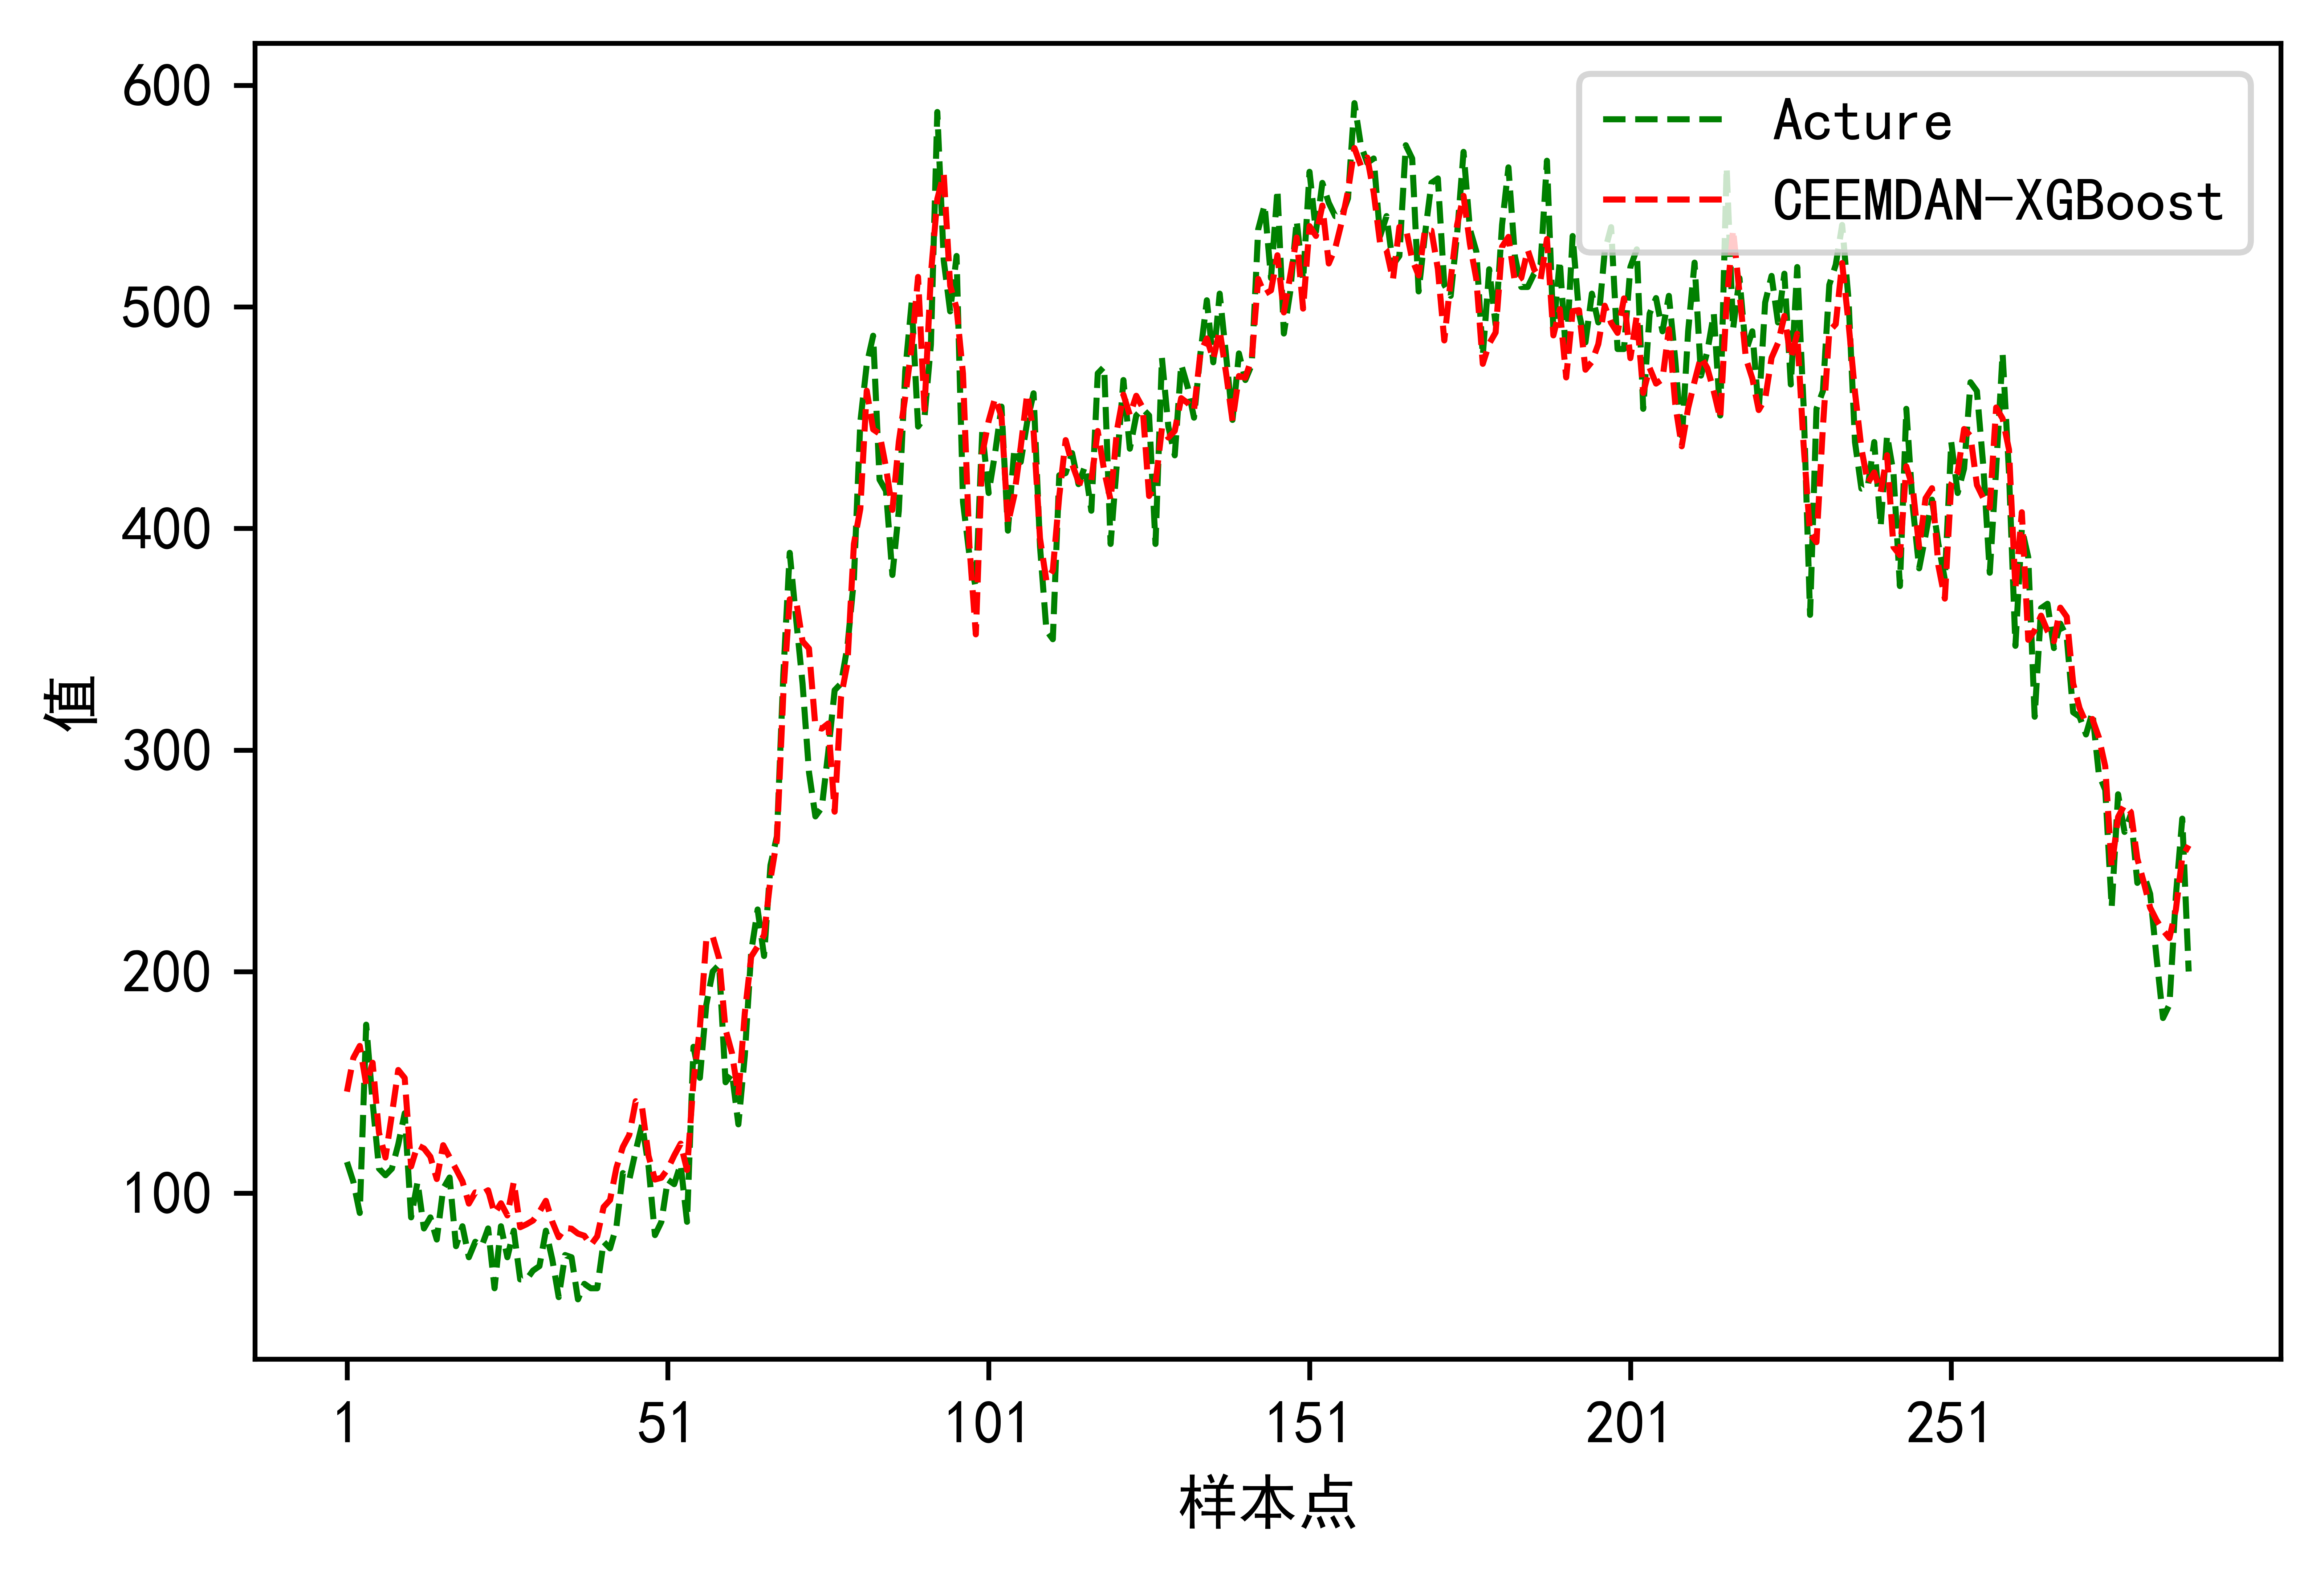

In [14]:
# 测试集
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif']=['Simhei']  #解决画图中文不显示问题
plt.figure(figsize=(6,4),dpi=600)
x=range(1, len(mean_pre_test) + 1)
plt.xticks(x[::50])
plt.tick_params(labelsize=10)  #改变刻度字体大小
plt.plot(x, mean_actual_test, linestyle="--",color='g',linewidth=1, label='Acture')
plt.plot(x, mean_pre_test,  color='red',linestyle="--",linewidth=1,label='CEEMDAN-XGBoost')
plt.rcParams.update({'font.size': 10})  #改变图例里面的字体大小
plt.legend(loc='upper right')
plt.xlabel("样本点",fontsize=10)
plt.ylabel("值",fontsize=10)
# plt.xlim(xmin=600,xmax=700)  #显示600-1000的值   局部放大有利于观察
# plt.savefig('台湾VMD-LSTM震级预测结果图.png')
plt.show()

In [15]:
# #保存预测结果
savemat('结果/ceemdan_xgboost_result.mat',{'true':mean_actual_test,'pred':mean_pre_test})